# Fruit Quality Prediction with a CNN using keras's built in methods

In this project we train 3 models to predict whether a fruit image contains a fresh or rotten fruit.
First we import the libraries and datasets that we need for preprocessing, training, and plotting

In [150]:
import os , shutil
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from matplotlib import image as img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
import cv2

In [42]:
original_dataset_dir ="/Users/TT/Desktop/Deep Learning/train"
validation_dataset_dir="/Users/TT/Desktop/Deep Learning/validation"
test_dataset_dir="/Users/TT/Desktop/Deep Learning/test"

First we will be using the raw image and rescaling it between 0 and 1, note that each image has three matrices, one for each RGB color.

In [3]:
train_datagen=ImageDataGenerator(rescale=1./255)
test_datagen=ImageDataGenerator(rescale=1./255)

When initializing the image generator I pass the data from the directory through the ImageDataGenerator function for resclaing, I ensure that all matrices have a (150,150) size and that the labels are binary. For quicker training time I will use a batch size of 200.

In [4]:
train_generator=train_datagen.flow_from_directory(
original_dataset_dir,
target_size=(150,150),
batch_size=200,
class_mode='binary')

Found 10901 images belonging to 2 classes.


In [5]:
validation_generator=test_datagen.flow_from_directory(
validation_dataset_dir,
target_size=(150,150),
batch_size=200,
class_mode='binary')

Found 5450 images belonging to 2 classes.


In [43]:
test_generator=test_datagen.flow_from_directory(
test_dataset_dir,
target_size=(150,150),
batch_size=200,
class_mode='binary')

Found 2698 images belonging to 2 classes.


We make sure that our data shape is (200, 150, 150, 3) and label shape is (200, ) .

In [6]:
for data_batch, labels_batch in train_generator:
    print('data batch shape', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break


data batch shape (200, 150, 150, 3)
labels batch shape: (200,)


We specify the path where we want to save our model weights and the frequency which is every epoch.

In [7]:
checkpoint_path="deep_learning/model_weights{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint = ModelCheckpoint(checkpoint_dir, 
                             monitor='val_Accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='auto', 
                             save_freq=55
                             )

We initialize our CNN, 8 layers of Conv2D and Maxpooling, then we add a Dense hidden layer of 6272 inputs and 512 neurons, with a relu activation for the hidden layer and sigmoid for the output.

In [8]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3),activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dense(1,activation='sigmoid'))

We will be using throughout this project the RMSprop optimizer and binary crossentropy for the loss (binary classification)

In [9]:
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [11]:
history=model.fit_generator(
train_generator,
steps_per_epoch=55,
callbacks=[checkpoint],
epochs=10,
validation_data=validation_generator,
validation_steps=14)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
55/55 [==============================] - 350s 6s/step - loss: 0.5775 - acc: 0.6683 - val_loss: 0.4448 - val_acc: 0.7829
Epoch 2/10
55/55 [==============================] - 322s 6s/step - loss: 0.4352 - acc: 0.7947 - val_loss: 0.3287 - val_acc: 0.8693
Epoch 3/10
55/55 [==============================] - 312s 6s/step - loss: 0.3705 - acc: 0.8329 - val_loss: 0.3435 - val_acc: 0.8421
Epoch 4/10
55/55 [==============================] - 314s 6s/step - loss: 0.3260 - acc: 0.8601 - val_loss: 0.2763 - val_acc: 0.8836
Epoch 5/10
55/55 [==============================] - 325s 6s/step - loss: 0.3030 - acc: 0.8718 - val_loss: 0.2333 - val_acc: 0.9146
Epoch 6/10
55/55 [==============================] - 315s 6s/step - loss: 0.2764 - acc: 0.8857 - val_loss: 0.2257 - val_acc: 0.9032
Epoch 7/10
55/55 [==============================] - 315s 6s/step - loss: 0.2611 - acc: 0.8945 - val_loss: 0.2179 - val_acc: 0.9193
Epoch 8

As we can see in the results the validation accuracy is higher than the training accuracy and the training loss is higher than the validation loss at 0.93 vs 0.91, and I am not using any regularization. So it might be that the validation set I chose is too easy and does not reflect accurately the all the data.

In [12]:
model.save_weights(checkpoint_path.format(epoch=0),overwrite=True)

<Figure size 432x288 with 0 Axes>

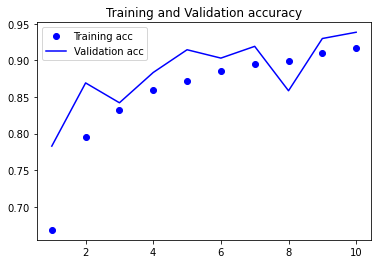

<Figure size 432x288 with 0 Axes>

In [13]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs, val_acc,'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()



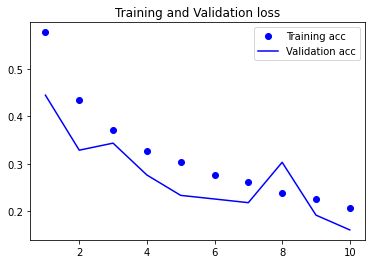

In [14]:
plt.plot(epochs,loss,'bo',label='Training acc')
plt.plot(epochs, val_loss,'b', label='Validation acc')
plt.title('Training and Validation loss')
plt.legend()

Let's evaluate against the testing set

In [44]:
model.evaluate(test_generator)

14/14 [==============================] - 22s 2s/step - loss: 0.1708 - acc: 0.9322


[0.17077727615833282, 0.9321720004081726]

# Training with Data Aumentation (model2)

For this part we will study the effect of data augmentation on the results of the model. We will use rotation, width and height shift, zoom,... To reduce overfitting I will also be adding a dropout of 0.5

In [15]:
train_datagen2= ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.2,
horizontal_flip=True,
    
)

In [16]:
test_datagen=ImageDataGenerator(rescale=1./255)

In [17]:
train_generator2=train_datagen2.flow_from_directory(
original_dataset_dir,
target_size=(150,150),
batch_size=200,
class_mode='binary')

Found 10901 images belonging to 2 classes.


In [18]:
validation_generator=test_datagen.flow_from_directory(
validation_dataset_dir,
target_size=(150,150),
batch_size=200,
class_mode='binary')

Found 5450 images belonging to 2 classes.


In [19]:
model2= models.Sequential()
model2.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model2.add(layers.MaxPooling2D(2,2))
model2.add(layers.Conv2D(64, (3,3), activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(128,(3,3),activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(128,(3,3),activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(512,activation='relu'))
model2.add(layers.Dense(1,activation='sigmoid'))

In [20]:
model2.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

In [21]:
history=model2.fit_generator(
train_generator2,
steps_per_epoch=55,
epochs=10,
callbacks=[checkpoint],
validation_data=validation_generator,
validation_steps=12)

Epoch 1/10
55/55 [==============================] - 345s 6s/step - loss: 0.6326 - acc: 0.6276 - val_loss: 0.5126 - val_acc: 0.7287
Epoch 2/10
55/55 [==============================] - 348s 6s/step - loss: 0.5300 - acc: 0.7277 - val_loss: 0.5628 - val_acc: 0.6942
Epoch 3/10
55/55 [==============================] - 359s 7s/step - loss: 0.4727 - acc: 0.7695 - val_loss: 0.3352 - val_acc: 0.8696
Epoch 4/10
55/55 [==============================] - 340s 6s/step - loss: 0.4230 - acc: 0.8059 - val_loss: 0.3235 - val_acc: 0.8617
Epoch 5/10
55/55 [==============================] - 334s 6s/step - loss: 0.3949 - acc: 0.8194 - val_loss: 0.2799 - val_acc: 0.8946
Epoch 6/10
55/55 [==============================] - 1817s 33s/step - loss: 0.3745 - acc: 0.8320 - val_loss: 0.3410 - val_acc: 0.8333
Epoch 7/10
55/55 [==============================] - 363s 7s/step - loss: 0.3556 - acc: 0.8427 - val_loss: 0.2700 - val_acc: 0.9050
Epoch 8/10
55/55 [==============================] - 358s 7s/step - loss: 0.3262 -

<Figure size 432x288 with 0 Axes>

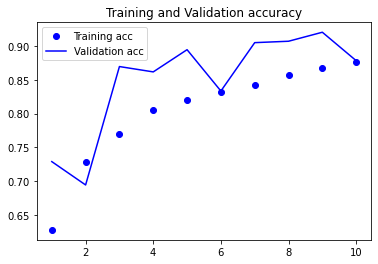

<Figure size 432x288 with 0 Axes>

In [22]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs, val_acc,'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

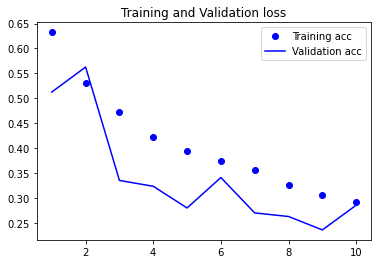

In [23]:
plt.plot(epochs,loss,'bo',label='Training acc')
plt.plot(epochs, val_loss,'b', label='Validation acc')
plt.title('Training and Validation loss')
plt.legend()

In [45]:
model2.evaluate(test_generator)

14/14 [==============================] - 20s 1s/step - loss: 0.3033 - acc: 0.8677


[0.3033343553543091, 0.8676797747612]

# I am choosing the VGG16 model as a Conv base and freezing all the weights, This will speed up learning. (model3)

In [24]:
conv_base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(150,150,3))

In [25]:
def extract_features(directory, sample_count):
    features=np.zeros(shape=(sample_count,4,4,512))
    labels=np.zeros(shape=(sample_count))
    generator = train_datagen.flow_from_directory(
    directory,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary')
    i=0
    for inputs_batch, labels_batch in generator:
        feature_batch=conv_base.predict(inputs_batch)
        features[i* 20: (i+1)*20]=feature_batch
        labels[i*20:(i+1)*20]=labels_batch
        i+=1
        if i*20>=sample_count:
            break
        return features,labels

In [122]:
train_features, train_labels = extract_features(original_dataset_dir, 10901)
validation_features, validation_labels = extract_features(validation_dataset_dir,5450)
test_features, test_labels = extract_features(test_dataset_dir,2698)

Found 10901 images belonging to 2 classes.
Found 5450 images belonging to 2 classes.
Found 2698 images belonging to 2 classes.


In [147]:
train_features=np.reshape(train_features,(10901,4*4*512))
validation_features = np.reshape(validation_features, (5450,4*4*512))
test_features = np.reshape(test_features, (2698,4*4*512))

# test predictions Oranges


Since our prediction class is binary, our threshold would be 0.5, our model here predicts below 0.5 for fresh fruit and above for rotten fruit.

In [197]:
def make_prediction(directory):
    image=img.imread(directory)
    resized_image=cv2.resize(image, (150, 150))
    reshaped_image=resized_image.reshape(1, 150, 150, 3)
    feature_conv_base=conv_base.predict(reshaped_image)
    image=feature_conv_base.reshape(1,8192)
    prediction=model3.predict(image)
    return prediction

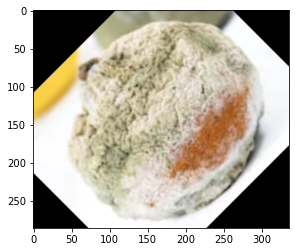

In [193]:
directory1="/Users/TT/Desktop/Deep Learning/test/rotten/rotated_by_45_Screen Shot 2018-06-12 at 11.43.03 PM.png"
image=img.imread(directory1)
plt.imshow(image)

In [194]:
make_prediction(directory1)

array([[0.9861983]], dtype=float32)

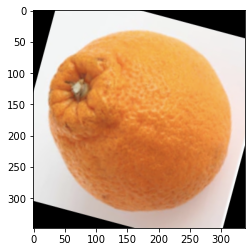

In [195]:
directory="/Users/TT/Desktop/Deep Learning/test/fresh/rotated_by_75_Screen Shot 2018-06-13 at 12.18.23 AM.png"
image=img.imread(directory2)
plt.imshow(image)

In [196]:
make_prediction(directory2)

array([[0.00014088]], dtype=float32)

# test predictions bananas

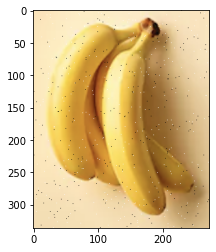

In [198]:
directory3='/Users/TT/Desktop/Deep Learning/test/fresh/saltandpepper_Screen Shot 2018-06-12 at 10.06.19 PM.png'
image=img.imread(directory3)
plt.imshow(image)

In [199]:
make_prediction(directory3)

array([[0.400044]], dtype=float32)

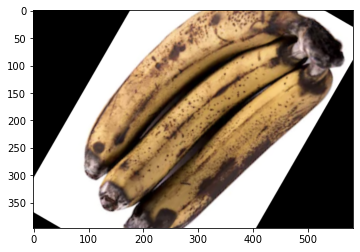

In [200]:
directory4='/Users/TT/Desktop/Deep Learning/test/rotten/rotated_by_60_Screen Shot 2018-06-12 at 8.51.46 PM.png'
image=img.imread(directory4)
plt.imshow(image)

In [201]:
make_prediction(directory4)

array([[0.97453535]], dtype=float32)

In [28]:
checkpoint_path="model_weights/model_weights{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint = ModelCheckpoint(checkpoint_dir, 
                             monitor='val_Accuracy', 
                             verbose=1,  
                             save_weights_only=True, 
                             mode='auto', 
                             save_freq=545
                             )


In [29]:
model3=models.Sequential()
model3.add(layers.Dense(256,activation='relu', input_dim=4*4*512))
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics='acc')

In [30]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [31]:
history=model3.fit(train_features,train_labels,
                  epochs=30,
                  callbacks=[checkpoint],
                  batch_size=20,
                  validation_data=(validation_features,validation_labels))

Epoch 1/30
544/546 [============================>.] - ETA: 0s - loss: 0.6782 - acc: 0.9993
Epoch 00001: saving model to model_weights
546/546 [==============================] - 12s 21ms/step - loss: 0.6781 - acc: 0.9993 - val_loss: 0.6586 - val_acc: 0.9982
Epoch 2/30
542/546 [============================>.] - ETA: 0s - loss: 0.6311 - acc: 0.9993
Epoch 00002: saving model to model_weights
546/546 [==============================] - 12s 23ms/step - loss: 0.6310 - acc: 0.9993 - val_loss: 0.6069 - val_acc: 0.9982
Epoch 3/30
540/546 [============================>.] - ETA: 0s - loss: 0.5742 - acc: 0.9994
Epoch 00003: saving model to model_weights
546/546 [==============================] - 12s 21ms/step - loss: 0.5743 - acc: 0.9993 - val_loss: 0.5477 - val_acc: 0.9982
Epoch 4/30
540/546 [============================>.] - ETA: 0s - loss: 0.5115 - acc: 0.9993
Epoch 00004: saving model to model_weights
546/546 [==============================] - 11s 21ms/step - loss: 0.5111 - acc: 0.9993 - val_los

In [32]:
location_model='VGG_16.model'
model.save(location_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: VGG_16.model\assets


<Figure size 432x288 with 0 Axes>

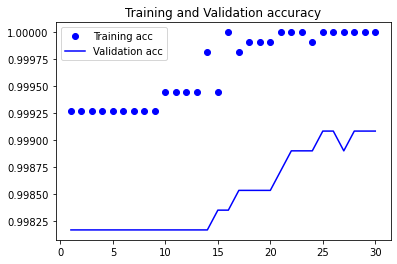

<Figure size 432x288 with 0 Axes>

In [33]:
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs, val_acc,'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()

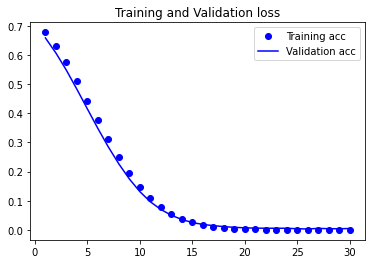

In [34]:
plt.plot(epochs,loss,'bo',label='Training acc')
plt.plot(epochs, val_loss,'b', label='Validation acc')
plt.title('Training and Validation loss')
plt.legend()

In [53]:
model3.evaluate(test_features, test_labels)

85/85 [==============================] - 0s 3ms/step - loss: 0.0043 - acc: 0.9985


[0.0043442645110189915, 0.9985173940658569]

# VGG16 model with data augmentation

In [35]:
model4=models.Sequential()
model4.add(conv_base)
model4.add(layers.Flatten())
model4.add(layers.Dense(256,activation='relu'))
model4.add(layers.Dense(1,activation='sigmoid'))

In [36]:
len(model4.trainable_weights)

30

In [37]:
conv_base.trainable=False

In [38]:
len(model4.trainable_weights)

4

In [ ]:
model2.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

In [54]:
history=model4.fit(train_features,train_labels,
                  epochs=30,
                  callbacks=[checkpoint],
                  batch_size=20,
                  validation_data=(validation_features,validation_labels))

RuntimeError: You must compile your model before training/testing. Use `model.compile(optimizer, loss)`.